In [106]:
import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from typing import List, Dict, Tuple, Any


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.ensemble import (RandomForestRegressor,
                              RandomForestClassifier)

pd.options.display.float_format = "{:.3f}".format
sns.set(style='darkgrid', context='talk', palette='rainbow')



%matplotlib inline

## TOC:
* [Introducción](#intro)
* [Sección 1](#section-1)
* [Sección 2](#section-2)

# Introducción <div id='intro'/>


Candidato: Adolfo Villalobos

Email: amvillalobos@uc.cl





El objetivo de este desafío tiene dos partes:
1. Demostrar y ejemplificar la aplicación de conceptos básicos de **data engineering** a un dataset de prueba, de manera que la data cruda pueda ser **extraída, transformada y cargada (ETL)** para su posterior análisis.
2. Demostrar capacidad de análisis y de generación de insights sobre la data, los cuales permitan en última instancia identificar acciones concretas para el negocio.

---


Trabajamos sobre una **muestra** proveniente del dataset **UCI Credit Card Default**. En este desafío, la data presenta algunas dificultades que deben ser resueltas previamente al análisis de datos:
1. El dataset se encuentra fragmentado en distintos archivos
2. El dataset puede presentar datos faltantes
3. El dataset puede presentar registros (filas) duplicados
4. El dataset puede presentar características (columnas) duplicadas


## Implementación


Separamos esta solución en dos secciones: **Data Engineering** (Sección 1) y **Data Analysis** (Sección 2).

En la Sección 1, nos enfocamos en extraer la data desde su fuente primaria, transformarla y finalmente guardarla para su posterior análisis.

En la Sección 2, planteamos algunas preguntas de negocio iniciales para motivar la exploración, para posteriormente plantear un caso de negocio en función de los datos y herramientas modernas de aprendizaje automatizado


### Limitaciones:

La solución actual presenta limitaciones, y por lo tanto las conclusiones obtenidas pueden cambiar en la medida que el tamaño de la muestra aumente.Esto se debe a que El dataset esta compuesto por 50 IDs distintas y 24 columnas.

Como consecuencia, la capacidad para generar **significancia estadística** es limitada. Adicionalmente, aplicar conceptos de **ingeniería de características** se verá fuertemente limitada debido a que habrá un mayor número de columnas que de filas en nuestro dataset. Por último, no se abordan frameworks mas modernos para la orchestación de pipelines de datos como **Apache Airflow** o **Kedro** debido a las restricciones de tiempo y la pequeñez del conjunto de datos.



# Sección 1: Data Engineering <a class="anchor" name="section-1"></a>

En esta etapa, cargamos los datos desde cada uno de los datasets y analizamos su contenido. Luego transformamos los datos para su posterior análisis, y finalmente los cargamos en un archivo de salida. Esto corresponde a un caso sencillo de la metodologia de **ETL**.

## Extracción



En cada uno de los 4 archivos, los pasos a seguir seran:
1. Cargar los **datos crudos** desde cada uno de los datasets en la carpeta `data/1_raw`. En este paso, especificamos typos de datos y lista de valores faltantes customizados.
2. Analizamos los data types obtenidos para cada columna
3. Investigamos si hay datos faltantes
4. Investigamos si hay datos duplicados


Finalmente, decidiremos qué características obtener.

### UCI_Credit_Card_BillATM.csv

In [2]:
def extract_bill_atm() -> pd.DataFrame:
    """Extrae la data a partir de un fichero de UCI_Credit_Card_BillATM.csv"""
    filename = "data/1_raw/UCI_Credit_Card_BillATM.csv"
    df = pd.read_csv(filename, index_col=0 ,na_values={"LIMIT_BAL": ["-"]}, dtype={"LIMIT_BAL": "float64"})

    df.set_index("ID", inplace=True)
    df.sort_index(inplace=True)

    return df

In [3]:
"""Extraemos la data y mostramos primeros elementos"""
df_bill_extract = extract_bill_atm()
df_bill_extract.head()

,LIMIT_BAL,SEX,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
ID,,,,,,,,
1,20000.000,female,3913.000,3102.000,689.000,0.000,0.000,0.000
1,20000.000,female,3913.000,3102.000,689.000,0.000,0.000,0.000
2,120000.000,NaN,2682.000,1725.000,2682.000,3272.000,3455.000,3261.000
3,90000.000,female,29239.000,14027.000,13559.000,14331.000,14948.000,15549.000
4,50000.000,female,46990.000,48233.000,49291.000,28314.000,28959.000,29547.000


In [4]:
"""Muestra los data types presentes en el dataset"""
df_bill_extract.dtypes

LIMIT_BAL    float64
SEX           object
BILL_AMT1    float64
BILL_AMT2    float64
BILL_AMT3    float64
BILL_AMT4    float64
BILL_AMT5    float64
BILL_AMT6    float64
dtype: object

In [5]:
"""Describe el dataset en función de estadísticos básicos"""
df_bill_extract.describe()

,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,46.000,52.000,52.000,52.000,52.000,52.000,52.000
mean,160652.174,40476.115,39074.577,38418.827,42871.423,32894.154,34781.923
std,157824.124,69774.513,73656.656,73852.238,113904.603,74466.870,75981.531
min,10000.000,-109.000,-425.000,-527.000,-923.000,-28335.000,-1884.000
25%,50000.000,4325.500,3163.500,1397.250,1822.500,505.750,504.250
50%,100000.000,15191.500,16311.000,15467.000,14835.000,15811.500,12770.500
75%,225000.000,47147.500,41968.750,38272.250,28428.250,29102.000,29671.750
max,630000.000,367965.000,412023.000,445007.000,628699.000,483003.000,473944.000


In [6]:
"""Muestra información del dataset en función de las columnas"""
df_bill_extract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 1 to 50
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  46 non-null     float64
 1   SEX        45 non-null     object 
 2   BILL_AMT1  52 non-null     float64
 3   BILL_AMT2  52 non-null     float64
 4   BILL_AMT3  52 non-null     float64
 5   BILL_AMT4  52 non-null     float64
 6   BILL_AMT5  52 non-null     float64
 7   BILL_AMT6  52 non-null     float64
dtypes: float64(7), object(1)
memory usage: 3.7+ KB


In [7]:
"""Cantidad de datos faltantes por columna"""
df_bill_extract.isna().sum()

LIMIT_BAL    6
SEX          7
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
dtype: int64

In [8]:
"""Registros con datos duplicados"""
df_bill_extract[df_bill_extract.duplicated()]

,LIMIT_BAL,SEX,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
ID,,,,,,,,
1,20000.000,female,3913.000,3102.000,689.000,0.000,0.000,0.000
6,50000.000,male,64400.000,57069.000,57608.000,19394.000,19619.000,20024.000



### Hallazgos
AL extraer los datos usando el metodo `extract_bill_atm`, notamos lo siguiente:

1. **Contenido** :
   1. Archivo contiene campos:  `ID`, `LIMIT_BALL`, `SEX`, `BILL_ATM1` hasta `BILL_ATM6`. Esto corresponde a una mezcla entre datos demográficos y de comportamiento financiero.
   2. El campo `ID` es el que mejor se ajusta para considerarlo como identificador único para cada uno de los individuos.
   3. `SEX` contiene valores categoricos `male` y `female`. En este momento, se encuentran en modo `string` y no en modo ``category``
   4. Los campos `BILL_ATM1` hasta `BILL_ATM6` son valores numéricos.
2. **Datos faltantes**: Campos `LIMIT_BALL` y `SEX` tienen valores faltantes.
3. **Duplicados**: Hay 2 valores de `ID` duplicadas.






### UCI_Credit_Card_PAY.csv

In [9]:
def extract_pay() -> pd.DataFrame:
    filename = "data/1_raw/UCI_Credit_Card_Pay.csv"
    df = pd.read_csv(filename, index_col=0, na_values={"LIMIT_BAL": ["-"], "AGE": ["No info"]}, dtype={"LIMIT_BAL":np.float64})

    df.set_index("ID", inplace=True)
    df.sort_index(inplace=True)
    return df


In [10]:
"""Extraemos la data y mostramos primeros elementos"""
df_pay_extract = extract_pay()
df_pay_extract.head()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
ID,,,,,,,,
1,20000.000,NaN,2,2,-1,-1,-2,-2
1,20000.000,NaN,2,2,-1,-1,-2,-2
2,120000.000,26 years,-1,2,0,0,0,2
3,90000.000,34 years,0,0,0,0,0,0
4,50000.000,37 years,0,0,0,0,0,0


In [11]:
"""Muestra los data types presentes en el dataset"""
df_pay_extract.dtypes

LIMIT_BAL    float64
AGE           object
PAY_0          int64
PAY_2          int64
PAY_3          int64
PAY_4          int64
PAY_5          int64
PAY_6          int64
dtype: object

In [12]:
"""Describe el dataset en función de estadísticos básicos"""
df_pay_extract.describe()

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,45.000,52.000,52.000,52.000,52.000,52.000,52.000
mean,157777.778,-0.115,-0.288,-0.327,-0.481,-0.481,-0.462
std,154226.647,1.003,1.054,1.115,0.980,0.939,1.111
min,20000.000,-2.000,-2.000,-2.000,-2.000,-2.000,-2.000
25%,50000.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000
50%,90000.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,250000.000,0.000,0.000,0.000,0.000,0.000,0.000
max,630000.000,2.000,2.000,2.000,2.000,2.000,2.000


In [13]:
"""Muestra información del dataset en función de las columnas"""
df_pay_extract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 1 to 50
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  45 non-null     float64
 1   AGE        44 non-null     object 
 2   PAY_0      52 non-null     int64  
 3   PAY_2      52 non-null     int64  
 4   PAY_3      52 non-null     int64  
 5   PAY_4      52 non-null     int64  
 6   PAY_5      52 non-null     int64  
 7   PAY_6      52 non-null     int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 3.7+ KB


In [14]:
"""Cantidad de datos faltantes por columna"""
df_pay_extract.isna().sum()

LIMIT_BAL    7
AGE          8
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
dtype: int64

In [15]:
"""Registros que contienen algún dato faltante"""
df_pay_extract[df_pay_extract.isna().any(axis=1)]

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
ID,,,,,,,,
1,20000.000,NaN,2,2,-1,-1,-2,-2
1,20000.000,NaN,2,2,-1,-1,-2,-2
6,50000.000,NaN,0,0,0,0,0,0
11,NaN,34 years,0,0,2,0,0,-1
16,50000.000,NaN,1,2,0,0,0,0
21,130000.000,NaN,0,0,0,0,0,-1
26,NaN,23 years,0,0,0,0,0,0
26,NaN,23 years,0,0,0,0,0,0
31,NaN,27 years,-1,-1,-1,-1,-1,-1


In [16]:
"""Cantidad de registros con datos duplicados"""
df_pay_extract.duplicated().sum()

2

In [17]:
"""Registros con datos duplicados"""
df_pay_extract[df_pay_extract.duplicated()]

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
ID,,,,,,,,
1,20000.000,NaN,2,2,-1,-1,-2,-2
26,NaN,23 years,0,0,0,0,0,0


### Hallazgos

AL extraer los datos usando el metodo `extract_card_pay`, notamos lo siguiente:

1. **Contenido**:
   1. Archivo contiene campos:  `ID`, `LIMIT_BALL`, `AGE`, `PAY_0` hasta `PAY_6`, saltandose `PAY_1`.
   2. `AGE` representa información demográfica. El campo debe ser depurado pues la edad está acompañada del string `years` que debe ser retirado para posibilidar tu tratamiento numérico.
   3. Los campos `PAY_0` hasta `PAY_6` son valores categoricos y representan comportamiento financiero.
2. **Datos Faltantes**: Campos `LIMIT_BALL` y `AGE` tienen valores faltantes. Estos valores faltantes no son los mismos que en las secciones anteriores, lo cual nos indica que podemos recuperar informacion perdida.
3. **Duplicados**:
   1. Hay valores de `ID` duplicadas.


### UCI_Credit_Card_PayATM.csv

In [18]:
def extract_pay_amt() -> pd.DataFrame:
    filename ="data/1_raw/UCI_Credit_Card_PayATM.csv"
    df = pd.read_csv(filename, index_col=0,  na_values={"LIMIT_BAL": ["-"], "EDUCATION": ["Null"]})


    df.set_index("ID", inplace=True)
    df.sort_index(inplace=True)
    return df

In [19]:
"""Extraemos la data y mostramos primeros elementos"""
df_pay_amt_extract = extract_pay_amt()
df_pay_amt_extract.head()

,LIMIT_BAL,EDUCATION,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,
1,20000.000,2.000,0.000,689.000,0.000,0.000,0.000,0.000
1,20000.000,2.000,0.000,689.000,0.000,0.000,0.000,0.000
2,120000.000,2.000,0.000,1000.000,1000.000,1000.000,0.000,2000.000
3,90000.000,NaN,1518.000,1500.000,1000.000,1000.000,1000.000,5000.000
4,NaN,2.000,2000.000,2019.000,1200.000,1100.000,1069.000,1000.000


In [21]:
df_pay_amt_extract.dtypes

LIMIT_BAL    float64
EDUCATION    float64
PAY_AMT1     float64
PAY_AMT2     float64
PAY_AMT3     float64
PAY_AMT4     float64
PAY_AMT5     float64
PAY_AMT6     float64
dtype: object

In [22]:
df_pay_amt_extract.describe()

,LIMIT_BAL,EDUCATION,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,45.000,45.000,52.000,52.000,52.000,52.000,52.000,52.000
mean,163555.556,1.756,4814.558,4920.519,5199.731,8909.442,7749.885,4025.827
std,153994.621,0.883,8879.390,8952.014,12122.670,27900.882,28067.827,10730.717
min,10000.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,50000.000,1.000,945.000,376.000,37.500,325.500,192.750,0.000
50%,100000.000,2.000,2003.500,1500.000,1000.500,1100.000,1031.000,898.500
75%,250000.000,2.000,3350.500,3811.500,4381.000,4600.000,3000.000,2125.000
max,630000.000,5.000,55000.000,40000.000,75940.000,188840.000,195599.000,51582.000


In [23]:
# Busqueda de valores faltantes
df_pay_amt_extract.isna().sum()

LIMIT_BAL    7
EDUCATION    7
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
dtype: int64

In [24]:
# Revisamos aquellas IDs que tienen valores faltantes
df_pay_amt_extract[df_pay_amt_extract.isna().any(axis=1)]

,LIMIT_BAL,EDUCATION,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,
3,90000.000,NaN,1518.000,1500.000,1000.000,1000.000,1000.000,5000.000
4,NaN,2.000,2000.000,2019.000,1200.000,1100.000,1069.000,1000.000
4,NaN,2.000,2000.000,2019.000,1200.000,1100.000,1069.000,1000.000
7,NaN,1.000,55000.000,40000.000,38000.000,20239.000,13750.000,13770.000
10,20000.000,NaN,0.000,0.000,0.000,13007.000,1122.000,0.000
13,630000.000,NaN,1000.000,6500.000,6500.000,6500.000,2870.000,0.000
24,450000.000,NaN,19428.000,1473.000,560.000,0.000,0.000,1128.000
27,NaN,1.000,0.000,1000.000,0.000,500.000,0.000,1000.000
28,NaN,3.000,1300.000,1300.000,1000.000,1500.000,1000.000,1012.000


In [25]:
df_pay_amt_extract.duplicated().sum()

2

In [26]:
df_pay_amt_extract[df_pay_amt_extract.duplicated()]

,LIMIT_BAL,EDUCATION,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,
1,20000.000,2.000,0.000,689.000,0.000,0.000,0.000,0.000
4,NaN,2.000,2000.000,2019.000,1200.000,1100.000,1069.000,1000.000


### Hallazgos

AL extraer los datos usando el metodo `extract_card_pay`, notamos lo siguiente:

1. **Contenido**: Archivo contiene campos:  `ID`, `LIMIT_BALL`, `AGE`, `PAY_0` hasta `PAY_6`, saltandose `PAY_1`.
   1. Los campos `PAY_0` hasta `PAY_6` son valores categoricos.
   2. `AGE` contiene el string 'years' que debe ser retirado para poder procesar las edades. Adicionalmente, hay una amplia variacion en las edades, por lo cual es conveniente agrupar las edades en rangos etarios.
   3. Los campos `PAY_0` hasta `PAY_6` son valores categoricos.
2. **Duplicados**: Hay ID's duplicadas.
3. **Datos Faltantes**: Campos `LIMIT_BALL` y `AGE` tienen valores faltantes. Estos valores faltantes no son los mismos que en la seccion 1.a, lo cual nos indica que podemos recuperar informacion perdida.


### UCI_Credit_Card_PayNextMonth.csv

In [27]:
def extract_pay_next() -> pd.DataFrame:
    df = pd.read_csv("data/1_raw/UCI_Credit_Card_PayNextMonth.csv", index_col=0, na_values={"SEX": ["Nan"]})

    df.set_index("ID", inplace=True)
    df.sort_index(inplace=True)
    return df

In [28]:
df_pay_next_extract = extract_pay_next()
df_pay_next_extract.head()

,SEX,EDUCATION,MARRIAGE,AGE,default.payment.next.month
ID,,,,,
1,2.000,2.000,1,24.000,1
2,2.000,2.000,2,26.000,1
3,2.000,2.000,2,34.000,0
4,2.000,NaN,1,37.000,0
5,1.000,2.000,1,57.000,0


In [29]:
df_pay_next_extract.dtypes

SEX                           float64
EDUCATION                     float64
MARRIAGE                        int64
AGE                           float64
default.payment.next.month      int64
dtype: object

In [30]:
df_pay_next_extract.describe()

,SEX,EDUCATION,MARRIAGE,AGE,default.payment.next.month
count,44.000,44.000,50.000,44.000,50.000
mean,1.545,1.659,1.760,33.273,0.260
std,0.504,0.745,0.476,9.520,0.443
min,1.000,1.000,1.000,22.000,0.000
25%,1.000,1.000,1.250,26.000,0.000
50%,2.000,1.500,2.000,30.000,0.000
75%,2.000,2.000,2.000,39.000,0.750
max,2.000,3.000,3.000,58.000,1.000


In [31]:
df_pay_next_extract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 1 to 50
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SEX                         44 non-null     float64
 1   EDUCATION                   44 non-null     float64
 2   MARRIAGE                    50 non-null     int64  
 3   AGE                         44 non-null     float64
 4   default.payment.next.month  50 non-null     int64  
dtypes: float64(3), int64(2)
memory usage: 2.3 KB


In [32]:
# Busqueda de valores faltantes
df_pay_next_extract.isna().sum()

SEX                           6
EDUCATION                     6
MARRIAGE                      0
AGE                           6
default.payment.next.month    0
dtype: int64

In [33]:
df_pay_next_extract[df_pay_next_extract.isna().any(axis=1)]

,SEX,EDUCATION,MARRIAGE,AGE,default.payment.next.month
ID,,,,,
4,2.000,NaN,1,37.000,0
7,1.000,NaN,2,29.000,0
11,2.000,3.000,2,NaN,0
14,NaN,2.000,2,30.000,1
19,NaN,1.000,1,49.000,0
23,NaN,2.000,2,26.000,1
25,NaN,1.000,2,23.000,0
26,1.000,3.000,2,NaN,0
27,1.000,NaN,2,27.000,1


In [34]:
df_pay_next_extract.duplicated().sum()

1

In [35]:
df_pay_next_extract[df_pay_next_extract.duplicated()]

,SEX,EDUCATION,MARRIAGE,AGE,default.payment.next.month
ID,,,,,
44,2.000,2.000,1,NaN,0


### Hallazgos

AL extraer los datos usando el metodo `extract_pay_next`, notamos lo siguiente:

1. **Contenido**  Contiene campos  `ID`, `SEX`, `EDUCATION`,  `AGE` y `default.payment.next.month`.
   1. `SEX`, `EDUCATION` y `AGE` corresponden a información demográfica y serán tratadas como variables categóricas.
   2. A diferencia de un caso anterior, el campo `AGE` no contiene el string `years` y por tanto puede ser procesado como un `float`.
   3. La variable `default.payment.next.month` corresponde a nuestra variable de interés pues representa si la persona entrará en default de su pago el siguiente mes.
2. **Datos Duplicados**: Hay 1 registro con `ID` duplicado para la persona `ID = 1`.
3. **Datos Faltantes** :
   1. `EDUCATION`,  `SEX` y `AGE` tienen valores faltantes. Estos valores faltantes no son los mismos que en la seccion 1.a, lo cual nos indica que podemos recuperar informacion perdida.
   2. La columna `default.payment.next.month` también tiene datos faltantes, ya que al eliminar duplicados nos quedaremos con 49 registros, lo cual signitica que dicha variable no será presente para alguno de los 50 perfiles.


### Conclusión

A continuación presentamos algunas conclusiones sobre los datos cargados, y las decisiones que se tomarán para su posterior procesamiento.


#### Datos Faltantes

 Las siguientes columnas presentan datos faltantes
   1.  Las siguientes columnas presentan datos faltantes: `LIMIT_BAL`, `SEX`, `AGE`, `MARRIAGE`, `EDUCATION` y `default.payment.next.month`.
   2.  Algunas de las columnas mencionadas actualmente se encuentran en mas de un dataset. Más aún, los datos faltantes en un dataset no son los mismos que en otro, por lo cual es posible en teoría recuperar algunos de los datos faltantes al unificar los datasets.
   3.  Otras columnas como `default.payment.next.month` presentan datos faltantes y se encuentran en un único dataset, por lo cual será necesario evaluar una imputación o un descarte.


#### Datos Duplicados

 Todos los dataset presentan al menos un `ID` duplicado. Es necesario eliminar dichos registros posteriormente con el objetivo no **sobre-representar** un determinado tipo de perfil en el análisis.


 #### Contenido y Estructura

El contenido de los datasets es sencillo de trabajar ya que:
1. La data es estructurada y está organizada tabularmente en base a un `schema` relacional basado en el campo `ID` como identificador único.
2. El tamaño de muestra es pequeño (`n=50`), por lo cual no es necesario utilizar un framework de computación en paralelo como `Apache Spark`, o un framework de orchestación de tareas como `Apache Airflow`

Las decisiones que tomamos sobre el contenido son:
1. Las variables `SEX`, `AGE`, `MARRIAGE`, `EDUCATION` :
   1. **Tipo**: Categórica.
   2. **Representa**: la demografía de los perfiles.
   3.  **Decisión**: Intuitivamente, sabemos que características como Sexo o edad pueden influir en la estabilidad financiera y propensión al riesgo de un individuo. Por tanto, deben ser analizadas.
2.  La variable `default.payment.next.month`:
     1.  **Tipo**: Categórica
     2.  **Representa**: si el perfil entrará o no en default el próximo mes.
     3.  **Decisión**:  Esta variable es **crucial**  si se desea utilizar un enfoque de aprendizaje automático (Machine Learning)  para identificar **factores que influyen en la probabilidad de default** y entrenar un **clasificador binario** que nos permita inferir si un cliente entrará en default ( `default.payment.next.month = 1`) o no  ( `default.payment.next.month = 0`).

3.  La variable `LIMIT_BAL`:
     1.  **Tipo**: Numérica
     2.  **Representa**: Monto total del crédito asignado al cliente.
     3.  **Decisión**:  Esta variable es **crucial** pues al analizar la relación entre el tamaño total del crédito, y la probabilidad de default, pueden surgir oportunidades de negocio. Intuitivamente, un tamaño muy alto de crédito debiese aumentar la probabilidad de default. Sin embargo, al mismo tiempo tenemos la hipótesis de clientes a los cuales **se les puede aumentar el tamaño del crédito sin dañar sustantivamente su capacidad de pago**, lo cual influiría positivamente en las ganancias del negocio.

4.  Las variables  `PAY_0`, `PAY_2`,  `PAY_3`,  `PAY_4`,  `PAY_5`,  `PAY_6`
    1. **Tipo**: Categórica
    2.  **Representa**: El **estado de retraso de los pagos en relación a un mes en especifico**.
    3.   **Decisión**: Intuitivamente, tenemos la **hipótesis** de que el **retraso en pagos anteriores** influye en el **retraso de los pagos futuros**. En otras palabras, una persona que ha sido mal pagador en el pasado probablemene lo seguirá siendo en el futuro. Si bien esto aún es una hipótesis, decidimos mantener esta información ya que será la analítica la que nos indicará si tenemos razón o no.
5.  Las variables  `PAY_AMT1`, `PAY_AMT2`,  `PAY_AMT3`,  `PAY_AMT4`,  `PAY_AMT5`,  `PAY_AMT6`
    1.  **Tipo**: Numérica.
    2.  **Representa** el **monto del pago anterior en relación a un mes en especifico**.
    3.   **Decisión**:  Intuitivamente, tenemos la **hipótesis** de que el **monto de los pagos anterior**  puede influir en la capacidad del cliente para cumplir con su cuota. En otras palabras, una persona que ha sido mal pagador en el pasado puede haberlo sido simplemente debido al tamaño de la cuota, y por lo tanto puede ser conveniente repactar la deuda. Similar al caso anterior, decidimos mantener esta información ya que será la analítica la que nos indicará si tenemos razón o no.
6.  Las variables  `BILL_AMT1`, `BILL_AMT2`,  `BILL_AMT3`,  `BILL_AMT4`,  `BILL_AMT5`,  `BILL_AMT6`
    1.  **Tipo**: Numérica.
    2.  **Representa** el **monto a pagar en un mes anterior**.
    3.   **Decisión**:  Intuitivamente, un cliente puede ser un mal pagador debido a que el monto de las cuotas es muy alto en relación a su ingreso, o bien un més en específico su monto a pagar esperado cambió significativamente, lo cual le impidió cumplir con su compromiso de pago. En caso afirmativo, sería posible analizar repactar la deuda a un monto mensual mas acorde a la realidad del cliente, reduciendo la probabilidad de default. Decidimos mantener esta información.


Por último, unificamos nuestra etapa de extracción de la data en el método `extract`, el cual nos permite extraer la data de las distitnas fuentes de manera sencilla

In [97]:
def extract():
    """Extrae los datos desde cada una de las fuentes"""

    print("Paso 1 ETL - Extracción")

    df_bill_extract = extract_bill_atm()
    df_pay_extract = extract_pay()
    df_pay_amt_extract = extract_pay_amt()
    df_pay_next_extract = extract_pay_next()

    return df_bill_extract, df_pay_extract, df_pay_amt_extract, df_pay_next_extract



In [98]:
df_bill_extract, df_pay_extract, df_pay_amt_extract, df_pay_next_extract = extract()

Paso 1 ETL - Extracción


## Transformacion

En el enunciado se nos pide seguir las siguientes transformaciones:
1. Unir los datasets (Paso 3)
2. Limpia, depurar e imputar la base de datos.
3. Homogeneizar y normalizar los datos

Entre las dificultades encontradas en los datos, se encuentran:
1. Columnas repetidas en más de un dataset.
2. Filas repetidas en los datasets
3. Datos faltantes en datasets en 1 o más columnas repetidas. Un dato puede estar faltante en un dataset, y presente en otro.
4. Variables categóricas que representan categorías binarias (`SEX` y `default.payment.next.month`)
5. Variables categóricas que representan múltiples categorías  (`MARRIAGE`, etc.)
6. Variables numéricas con alta variabilidad y/o necesidad de binarización.

Por lo tanto, iniciar el proceso de Transformación con un `merge` resulta poco conveniente ya que nos encontaremos con múltiples versiones de la mismas columnas, las cuales se encuentran en distintos formatos. Adicionalmente, para datasets de tamaño mayor, un `merge` directo sin un preprocesamiento previo puede agotar la memoria ram del sistema (esto requiere optimizar data types, etc.).


---

En base a todo lo anterior, nuestra estrategia para la etapa de Transformación del **ETL** será:
1. Limpieza y conversión de los datasets por separado, con el objetivo de llevarlos a un `schema` commùn que nos permita simplifcar el `merge`
2. `merge` de los datasets a partir de la llave ùnica `ID`. Como veremos mas adelante, aprovechamos este paso para recuerar datos faltantes.
1. Imputación
2. Transformación de nombres
3. Transformación de categorías y bining


**NOTA**: Omitimos la Transformación por normalización de variables numéricas en esta etapa (e.g. escalamiento gaussiano), ya que al normalizar un set de datos, no es posible recuperar los datos originales sin guardar también los parámetros de la normalización.

Adicionalmente, para efectos de interpretabilidad y visualización, manetenemos los datos numéricos restantes sin normalizar. No obstante, a la hora de utilizar un enfoque de aprendizaje supervisado como regresión o clustering de los datos, es escencial normalizar los datos numéricos para así posibilidar la comparación entre distintos campos, y mejorar la performance del modelo. 





### Conversión de Data Types

En este apartado definimos las transformaciones necesarias para cumplir con nuestros requirimientos de `data types` en cada una de las variables.

In [75]:
def transform_clean_bill_atm(data: pd.DataFrame) -> pd.DataFrame:
    """Transforma el dataset UCI_Credit_Card_BillATM.csv"""
    df = data.copy()

    df["SEX"] = df["SEX"].astype("category")
    df.drop_duplicates(inplace=True)
    return df

def transform_clean_card_pay(data: pd.DataFrame) -> pd.DataFrame:
    """Transforma el dataset UCI_Credit_Card_Pay.csv"""
    df = data.copy()

    df["AGE"] = df["AGE"].astype(str).str.extract('(\d+)')
    df["AGE"] = df["AGE"].astype("Int64", errors="ignore")

    pay_cols = [c for c in df.columns if "PAY" in c]
    for c in pay_cols:
        df[c] = df[c].astype("category")


    df.drop_duplicates(inplace=True)
    return df



def transform_clean_card_pay_amt(data: pd.DataFrame) -> pd.DataFrame:
    """Transforma el dataset UCI_Credit_Card_PayATM.csv"""

    df = data.copy()

    df["EDUCATION"] = df["EDUCATION"].astype("category", errors="ignore")
    df.drop_duplicates(inplace=True)
    return df


def transform_clean_card_pay_next_month(data: pd.DataFrame) -> pd.DataFrame:
    """Transforma el dataset UCI_Credit_Card_PayNextMonth.csv"""

    df = data.copy()


    df.loc[df["SEX"] == 1.0, "SEX"] = "male"
    df.loc[df["SEX"] == 2.0, "SEX"] = "female"

    df["SEX"] = df["SEX"].astype("category")
    df["MARRIAGE"] = df["MARRIAGE"].astype("category")
    df["AGE"] = df["AGE"].astype("Int64", errors="ignore")
    df["EDUCATION"] = df["EDUCATION"].astype("category", errors="ignore")
    df["default.payment.next.month"] = df["default.payment.next.month"].astype("category", errors="ignore")

    df.drop_duplicates(inplace=True)
    return df




In [39]:
df_bill_clean = transform_clean_bill_atm(df_bill_extract)
df_bill_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 1 to 50
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LIMIT_BAL  44 non-null     float64 
 1   SEX        43 non-null     category
 2   BILL_AMT1  50 non-null     float64 
 3   BILL_AMT2  50 non-null     float64 
 4   BILL_AMT3  50 non-null     float64 
 5   BILL_AMT4  50 non-null     float64 
 6   BILL_AMT5  50 non-null     float64 
 7   BILL_AMT6  50 non-null     float64 
dtypes: category(1), float64(7)
memory usage: 3.3 KB


In [40]:
df_pay_clean = transform_clean_card_pay(df_pay_extract)
df_pay_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 1 to 50
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LIMIT_BAL  44 non-null     float64 
 1   AGE        43 non-null     Int64   
 2   PAY_0      50 non-null     category
 3   PAY_2      50 non-null     category
 4   PAY_3      50 non-null     category
 5   PAY_4      50 non-null     category
 6   PAY_5      50 non-null     category
 7   PAY_6      50 non-null     category
dtypes: Int64(1), category(6), float64(1)
memory usage: 2.7 KB


In [42]:
df_pay_amt_clean = transform_clean_card_pay_amt(df_pay_amt_extract)
df_pay_amt_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 1 to 50
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LIMIT_BAL  44 non-null     float64 
 1   EDUCATION  43 non-null     category
 2   PAY_AMT1   50 non-null     float64 
 3   PAY_AMT2   50 non-null     float64 
 4   PAY_AMT3   50 non-null     float64 
 5   PAY_AMT4   50 non-null     float64 
 6   PAY_AMT5   50 non-null     float64 
 7   PAY_AMT6   50 non-null     float64 
dtypes: category(1), float64(7)
memory usage: 3.4 KB


In [43]:
df_pay_next_clean = transform_clean_card_pay_next_month(df_pay_next_extract)
df_pay_next_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 1 to 50
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   SEX                         43 non-null     category
 1   EDUCATION                   43 non-null     category
 2   MARRIAGE                    49 non-null     category
 3   AGE                         44 non-null     Int64   
 4   default.payment.next.month  49 non-null     category
dtypes: Int64(1), category(4)
memory usage: 1.5 KB


### Unión y recuperación datos faltantes


Como mencionamos anteriormente, existen columnas con `datos faltantes` que tienen potencial de recuperación sin necesidad de un método de imputación. Esto gracias a que hay variables como `SEX` que se encuentran repetidas en mas de un dataset, y cuyos datos faltantes no son los mismos en cada caso.

A modo de ejemplo, el perfil con `ID = 2` presenta el campo `SEX` faltante en el dataset `UCI_Credit_Card_BillATM`, pero si lo buscamos en `UCI_Credit_Card_PayNextMonth`, el campo si se encuentra disponible (`female`)

In [45]:
display(df_bill_clean.loc[[2], :].T)
display(df_pay_next_clean.loc[[2], :].T)

ID,2
LIMIT_BAL,120000.000
SEX,NaN
BILL_AMT1,2682.000
BILL_AMT2,1725.000
BILL_AMT3,2682.000
BILL_AMT4,3272.000
BILL_AMT5,3455.000
BILL_AMT6,3261.000


ID,2
SEX,female
EDUCATION,2.000
MARRIAGE,2
AGE,26
default.payment.next.month,1


In [47]:
def get_nan_cols(data: Dict[str, pd.DataFrame]) -> List[str]:
    """Obtiene las columnas con datos faltantes en alguno de los datasets"""
    nan_cols = []
    for key, value in data.items():
        na = [col for col in value.columns if value[col].isnull().sum()   > 0]
        nan_cols.extend(na)
    nan_cols = list(set(nan_cols))

    return nan_cols

data = {
    "bill_atm": df_bill_clean,
    "card_pay": df_pay_clean,
    "card_pay_atm": df_pay_amt_clean,
    "card_pay_next": df_pay_next_clean,
}


nan_cols = get_nan_cols(data=data)
print(nan_cols)



['EDUCATION', 'SEX', 'AGE', 'LIMIT_BAL']


Para completar los datos faltantes que puedan ser repurados de alguno de los datasets, usamos el método `pd.DataFrame.combine_first` que permite completar los valores faltantes en las columnas de un dataset `df_left` a partir de las mismas columnas en un dataset `df_right`

In [51]:
def transform_combine(data: Dict[str, pd.DataFrame]) ->  pd.DataFrame:
    """Reemplaza valores faltantes combinando los valores presentes en otros datasets"""
    data_copy = data.copy()
    df = None
    for key in data_copy.keys():
        if df is None:
            df = data_copy[key]
        else:
            df = df.combine_first(data_copy[key])
    return df




In [52]:
df_combine = transform_combine(data=data)

df_combine.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 1 to 50
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   AGE                         50 non-null     Int64   
 1   BILL_AMT1                   50 non-null     float64 
 2   BILL_AMT2                   50 non-null     float64 
 3   BILL_AMT3                   50 non-null     float64 
 4   BILL_AMT4                   50 non-null     float64 
 5   BILL_AMT5                   50 non-null     float64 
 6   BILL_AMT6                   50 non-null     float64 
 7   EDUCATION                   49 non-null     float64 
 8   LIMIT_BAL                   50 non-null     float64 
 9   MARRIAGE                    49 non-null     category
 10  PAY_0                       50 non-null     category
 11  PAY_2                       50 non-null     category
 12  PAY_3                       50 non-null     category
 13  PAY_4                 

In [53]:
"""Volvemos a analizar la data faltante"""
df_combine.isna().sum().sort_values(ascending=False).T

default.payment.next.month    1
EDUCATION                     1
MARRIAGE                      1
PAY_4                         0
SEX                           0
PAY_AMT6                      0
PAY_AMT5                      0
PAY_AMT4                      0
PAY_AMT3                      0
PAY_AMT2                      0
PAY_AMT1                      0
PAY_6                         0
PAY_5                         0
AGE                           0
BILL_AMT1                     0
PAY_2                         0
PAY_0                         0
LIMIT_BAL                     0
BILL_AMT6                     0
BILL_AMT5                     0
BILL_AMT4                     0
BILL_AMT3                     0
BILL_AMT2                     0
PAY_3                         0
dtype: int64

### Imputacion

Al finalizar nuestra transformacion y union de los datasets, analizamos los datos faltantes

In [61]:
df_combine.isna().sum().sort_values(ascending=False).T

default.payment.next.month    1
EDUCATION                     1
MARRIAGE                      1
PAY_4                         0
SEX                           0
PAY_AMT6                      0
PAY_AMT5                      0
PAY_AMT4                      0
PAY_AMT3                      0
PAY_AMT2                      0
PAY_AMT1                      0
PAY_6                         0
PAY_5                         0
AGE                           0
BILL_AMT1                     0
PAY_2                         0
PAY_0                         0
LIMIT_BAL                     0
BILL_AMT6                     0
BILL_AMT5                     0
BILL_AMT4                     0
BILL_AMT3                     0
BILL_AMT2                     0
PAY_3                         0
dtype: int64

In [62]:
df_combine[df_combine.isna().any(axis=1)]

,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,EDUCATION,LIMIT_BAL,MARRIAGE,...,PAY_5,PAY_6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX,default.payment.next.month
ID,,,,,,,,,,,,,,,,,,,,,
44,37,59504.000,61544.000,62925.000,64280.000,67079.000,69802.000,NaN,140000.000,NaN,...,0,0,3000.000,3000.000,3000.000,4000.000,4000.000,3000.000,female,NaN


Podemos ver que aun tenemos valores faltantes en nuestro dataset.
1. De los 50 registros presentes, solo uno (ID 44) posee valores faltantes en las variables: `mariage`, `education` y `default`. Esto corresponde al 2% de los datos.
2. Dado que nuestro interes se enfoca en la variable `default`, a pesar de nuestro limitado número de registros, imputar una variable dependiente es considerada una practica poco desable e incluso contra-producente.

Un enfoque usual para manejar este tipo de situaciones es replicar el posterior análisis bajo los siguientes escenarios, y comparar los resultados para concluir la imputación tuvoe algún efecto:
1. No imputar: Simplemente eliminar registros con valores faltantes.
2. Impuitar valores faltantes en las variables `mariage`, `education` y `default`. Para ello, un metodo comun es imputar las variables dependientes `mariage` y `education`, para posteriormente imputar `default` en base a un modelo de regresion.

En nuestro caso, por simplicidad y dado que de todas maneras las conclusiones no serán confiables en ambos casos debido al tamaño de muestra, decidimos** no imputar** el dato faltante debido a que espeficiamente nos falta la variable de interés. Si `default` estuviera presente, entonces procederiamos a imputar las variables. 

Una módulo sencillo para imputar se encuentra disponible en la librería `scikit-learn`.



In [63]:
def transform_missing_values(data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()
    df.dropna(inplace=True)
    return df

df_missing= transform_missing_values(data=df_combine)
df_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 1 to 50
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   AGE                         49 non-null     Int64   
 1   BILL_AMT1                   49 non-null     float64 
 2   BILL_AMT2                   49 non-null     float64 
 3   BILL_AMT3                   49 non-null     float64 
 4   BILL_AMT4                   49 non-null     float64 
 5   BILL_AMT5                   49 non-null     float64 
 6   BILL_AMT6                   49 non-null     float64 
 7   EDUCATION                   49 non-null     float64 
 8   LIMIT_BAL                   49 non-null     float64 
 9   MARRIAGE                    49 non-null     category
 10  PAY_0                       49 non-null     category
 11  PAY_2                       49 non-null     category
 12  PAY_3                       49 non-null     category
 13  PAY_4                 

In [64]:
"""Ya no hay datos faltantes"""
df_missing[df_missing.isna().any(axis=1)]

,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,EDUCATION,LIMIT_BAL,MARRIAGE,...,PAY_5,PAY_6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX,default.payment.next.month
ID,,,,,,,,,,,,,,,,,,,,,



### Transformación de nombres de columnas


In [66]:
def transform_rename(data:  pd.DataFrame) ->  pd.DataFrame:
    """Cambia nombres de variables y los lleva a minúscula"""

    df = data.copy()

    df = df.rename(columns={"PAY_0": "PAY_1", "default.payment.next.month": "DEFAULT"})
    df.columns = [c.lower().replace(" ", "_") for c in df.columns]
    return df

In [67]:
df_rename = transform_rename(df_missing)
df_rename.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 1 to 50
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        49 non-null     Int64   
 1   bill_amt1  49 non-null     float64 
 2   bill_amt2  49 non-null     float64 
 3   bill_amt3  49 non-null     float64 
 4   bill_amt4  49 non-null     float64 
 5   bill_amt5  49 non-null     float64 
 6   bill_amt6  49 non-null     float64 
 7   education  49 non-null     float64 
 8   limit_bal  49 non-null     float64 
 9   marriage   49 non-null     category
 10  pay_1      49 non-null     category
 11  pay_2      49 non-null     category
 12  pay_3      49 non-null     category
 13  pay_4      49 non-null     category
 14  pay_5      49 non-null     category
 15  pay_6      49 non-null     category
 16  pay_amt1   49 non-null     float64 
 17  pay_amt2   49 non-null     float64 
 18  pay_amt3   49 non-null     float64 
 19  pay_amt4   49 non-null     floa

### Transformación categorías y bining

In [112]:

def transform_age_bining(data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()
    bins = [0, 25, 42, 58, 68, 101]
    labels = ['Gen Z', 'Milenials', 'Gen X', 'Boomers', "WWII"]
    df["age_by_bin"] = pd.cut(df["age"].astype("float"), bins, labels=labels, right=True)

    df.drop(["age"], axis=1, inplace=True)

    df.dropna(inplace=True)

    return df

def transform_categories(data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()
    df.replace(
        {'sex': {1 : 'Male', 2 : 'Female'},
        'education' : {1 : 'Graduate School', 2 : 'University', 3 : 'High School', 4 : 'Others', 5: "Others"},
        'marriage' : {1 : 'Married', 2 : 'Single', 3 : 'Others'}
                },
               inplace = True)
    df["default"] = df["default"].astype("int").astype("category")
    return df




In [113]:
df_norm = transform_age_bining(df_rename)
df_transform = transform_categories(df_norm)

df_transform.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 1 to 50
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   bill_amt1   49 non-null     float64 
 1   bill_amt2   49 non-null     float64 
 2   bill_amt3   49 non-null     float64 
 3   bill_amt4   49 non-null     float64 
 4   bill_amt5   49 non-null     float64 
 5   bill_amt6   49 non-null     float64 
 6   education   49 non-null     object  
 7   limit_bal   49 non-null     float64 
 8   marriage    49 non-null     category
 9   pay_1       49 non-null     category
 10  pay_2       49 non-null     category
 11  pay_3       49 non-null     category
 12  pay_4       49 non-null     category
 13  pay_5       49 non-null     category
 14  pay_6       49 non-null     category
 15  pay_amt1    49 non-null     float64 
 16  pay_amt2    49 non-null     float64 
 17  pay_amt3    49 non-null     float64 
 18  pay_amt4    49 non-null     float64 
 19  pay_amt5  

In [114]:
df_transform.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 1 to 50
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   bill_amt1   49 non-null     float64 
 1   bill_amt2   49 non-null     float64 
 2   bill_amt3   49 non-null     float64 
 3   bill_amt4   49 non-null     float64 
 4   bill_amt5   49 non-null     float64 
 5   bill_amt6   49 non-null     float64 
 6   education   49 non-null     object  
 7   limit_bal   49 non-null     float64 
 8   marriage    49 non-null     category
 9   pay_1       49 non-null     category
 10  pay_2       49 non-null     category
 11  pay_3       49 non-null     category
 12  pay_4       49 non-null     category
 13  pay_5       49 non-null     category
 14  pay_6       49 non-null     category
 15  pay_amt1    49 non-null     float64 
 16  pay_amt2    49 non-null     float64 
 17  pay_amt3    49 non-null     float64 
 18  pay_amt4    49 non-null     float64 
 19  pay_amt5  

### Encapsulado

Combinamos todos los procesos de transformación que hicimos en un único método **transform()** para encapsular la funcionalidad y asegurar la replicabilidad del proceso.

In [115]:
def transform(df_bill_extract: pd.DataFrame, df_pay_extract: pd.DataFrame, df_pay_amt_extract: pd.DataFrame, df_pay_next_extract: pd.DataFrame) -> pd.DataFrame:


    df_bill_clean = transform_clean_bill_atm(df_bill_extract)
    df_pay_clean = transform_clean_card_pay(df_pay_extract)
    df_pay_amt_clean = transform_clean_card_pay_amt(df_pay_amt_extract)
    df_pay_next_clean = transform_clean_card_pay_next_month(df_pay_next_extract)

    df_combine = transform_combine(data=data)
    df_missing= transform_missing_values(data=df_combine)

    df_rename = transform_rename(df_missing)

    df_norm = transform_age_bining(df_rename)
    df_transform = transform_categories(df_norm)

    return df_transform

In [116]:
df_transform = transform(df_bill_extract, df_pay_extract, df_pay_amt_extract, df_pay_next_extract)
df_transform.head()

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,education,limit_bal,marriage,pay_1,...,pay_6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,sex,default,age_by_bin
ID,,,,,,,,,,,,,,,,,,,,,
1,3913.000,3102.000,689.000,0.000,0.000,0.000,University,20000.000,Married,2,...,-2,0.000,689.000,0.000,0.000,0.000,0.000,female,1,Gen Z
2,2682.000,1725.000,2682.000,3272.000,3455.000,3261.000,University,120000.000,Single,-1,...,2,0.000,1000.000,1000.000,1000.000,0.000,2000.000,female,1,Milenials
3,29239.000,14027.000,13559.000,14331.000,14948.000,15549.000,University,90000.000,Single,0,...,0,1518.000,1500.000,1000.000,1000.000,1000.000,5000.000,female,0,Milenials
4,46990.000,48233.000,49291.000,28314.000,28959.000,29547.000,University,50000.000,Married,0,...,0,2000.000,2019.000,1200.000,1100.000,1069.000,1000.000,female,0,Milenials
5,8617.000,5670.000,35835.000,20940.000,19146.000,19131.000,University,50000.000,Married,-1,...,0,2000.000,36681.000,10000.000,9000.000,689.000,679.000,male,0,Gen X


## Load y Completar ETL

Completamos el proceso de **Data Engineering** implementando los método *load_data()** y  **etl()**. El primero corresonde a la última etapa del proceso de ETL: Extracción (Extract), Transformación (Transform) y Carga (Load), mientas que **etl()** encapsula el proceso completo.

In [206]:
def load_data(df: pd.DataFrame, filename: str, index: bool = True) -> pd.DataFrame:
    """Implementa la etapa Load en el ETL. En nuestro caso, genera un archivo CSV de salida"""
    print(f"Saving to: {filename}")
    df.to_csv(filename, index=index)
    return df


In [118]:
df = load_data(df=df_transform, filename="data/2_intermediate/etl_output.csv")

Saving to: data/2_intermediate/etl_output.csv


In [119]:
def etl():
    """Implementa el proceso de ETL completo"""
    dataframes = extract()
    transformed = transform(*dataframes)
    df = load_data(df=transformed, filename="data/2_intermediate/etl_output.csv")

    return df


In [120]:
"""Llamamos al método ETL"""
df = etl()

df.head()

Paso 1 ETL - Extracción
Saving to: data/2_intermediate/etl_output.csv


,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,education,limit_bal,marriage,pay_1,...,pay_6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,sex,default,age_by_bin
ID,,,,,,,,,,,,,,,,,,,,,
1,3913.000,3102.000,689.000,0.000,0.000,0.000,University,20000.000,Married,2,...,-2,0.000,689.000,0.000,0.000,0.000,0.000,female,1,Gen Z
2,2682.000,1725.000,2682.000,3272.000,3455.000,3261.000,University,120000.000,Single,-1,...,2,0.000,1000.000,1000.000,1000.000,0.000,2000.000,female,1,Milenials
3,29239.000,14027.000,13559.000,14331.000,14948.000,15549.000,University,90000.000,Single,0,...,0,1518.000,1500.000,1000.000,1000.000,1000.000,5000.000,female,0,Milenials
4,46990.000,48233.000,49291.000,28314.000,28959.000,29547.000,University,50000.000,Married,0,...,0,2000.000,2019.000,1200.000,1100.000,1069.000,1000.000,female,0,Milenials
5,8617.000,5670.000,35835.000,20940.000,19146.000,19131.000,University,50000.000,Married,-1,...,0,2000.000,36681.000,10000.000,9000.000,689.000,679.000,male,0,Gen X


# Sección 2: Data Analysis <a class="anchor" id="section-2"></a>


El área de Data Analysis se puede extender en varias direcciones. En nuestro caso, abordamos brevemente 3 áreas de interés

1. **Exploración**: Analizamos visualmente nuestro dataset en búsqueda de insight que nos permitan entender si hay algún tipo de relación entre la probabilidad de default y el resto de nuestras variables.
2. **Feature Engineering**: La Data que tenemos podría ser bastante limitada en términos de su expresividad, y es necesario calcular nuevas características en función de las que ya tenemos para generar mayores insights.
3. **Caso de Negocio**. Proponemos caminos para poder aumentar las ganancias del negocio en base a un modelo de aprendizaje supervisado.


## Exploración

### Estadísticos Descriptivos




####  Desbalace de Clases

In [160]:
"""Analizar balance de clases en las distintas categóricas"""

categorical_columns = ["default", "age_by_bin", "sex", "marriage", "education"]

for cat in categorical_columns:
    props = df[cat].value_counts() / df[cat].value_counts().sum()

    print(f"Col: {cat}: \n\t{props.T}")
    print("---")

Col: default: 
	0   0.735
1   0.265
Name: default, dtype: float64
---
Col: age_by_bin: 
	Milenials   0.592
Gen Z       0.245
Gen X       0.163
Boomers     0.000
WWII        0.000
Name: age_by_bin, dtype: float64
---
Col: sex: 
	female   0.510
male     0.490
Name: sex, dtype: float64
---
Col: marriage: 
	Single    0.735
Married   0.245
Others    0.020
Name: marriage, dtype: float64
---
Col: education: 
	Graduate School   0.490
University        0.327
High School       0.163
Others            0.020
Name: education, dtype: float64
---


#### Distribución

In [146]:
"""Analisis de la distribucion y variabilidad"""

df.describe()

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,limit_bal,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,expected_bill,expected_bill_amount,expected_pay_amount
count,49.000,49.000,49.000,49.000,49.000,49.000,49.000,49.000,49.000,49.000,49.000,49.000,49.000,49.000,49.000,49.000
mean,40345.735,38982.918,38297.082,43788.571,33138.735,35078.245,164693.878,5007.286,5105.286,5432.367,9350.837,8120.918,4190.673,229631.286,229631.286,37207.367
std,71592.090,75631.692,75796.983,117153.612,76428.242,77965.611,156977.998,9111.356,9191.686,12453.572,28696.474,28886.432,11034.808,473614.584,473614.584,68017.059
min,-109.000,-425.000,-527.000,-923.000,-28335.000,-1884.000,10000.000,0.000,0.000,0.000,0.000,0.000,0.000,-394.000,-394.000,0.000
25%,4463.000,3184.000,1473.000,2040.000,632.000,567.000,50000.000,1000.000,316.000,50.000,334.000,257.000,0.000,26919.000,26919.000,6246.000
50%,15054.000,16138.000,15134.000,14331.000,14948.000,11873.000,100000.000,2007.000,1500.000,1000.000,1100.000,1000.000,800.000,97082.000,97082.000,11010.000
75%,41087.000,29618.000,35835.000,28314.000,28959.000,29547.000,250000.000,3415.000,4500.000,5398.000,6400.000,3000.000,2000.000,196416.000,196416.000,39567.000
max,367965.000,412023.000,445007.000,628699.000,483003.000,473944.000,630000.000,55000.000,40000.000,75940.000,188840.000,195599.000,51582.000,2724595.000,2724595.000,361897.000


#### Riesgo de Pérdida

In [161]:
bill_cols = [c for c in df.columns if "bill_amt" in c]
pay_cols = [c for c in df.columns if "pay_amt" in c]
df["expected_bill_amount"] = df[bill_cols].sum(axis=1)
df["expected_pay_amount"] = df[pay_cols].sum(axis=1)

df.describe()

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,limit_bal,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,expected_bill,expected_bill_amount,expected_pay_amount
count,49.000,49.000,49.000,49.000,49.000,49.000,49.000,49.000,49.000,49.000,49.000,49.000,49.000,49.000,49.000,49.000
mean,40345.735,38982.918,38297.082,43788.571,33138.735,35078.245,164693.878,5007.286,5105.286,5432.367,9350.837,8120.918,4190.673,229631.286,229631.286,37207.367
std,71592.090,75631.692,75796.983,117153.612,76428.242,77965.611,156977.998,9111.356,9191.686,12453.572,28696.474,28886.432,11034.808,473614.584,473614.584,68017.059
min,-109.000,-425.000,-527.000,-923.000,-28335.000,-1884.000,10000.000,0.000,0.000,0.000,0.000,0.000,0.000,-394.000,-394.000,0.000
25%,4463.000,3184.000,1473.000,2040.000,632.000,567.000,50000.000,1000.000,316.000,50.000,334.000,257.000,0.000,26919.000,26919.000,6246.000
50%,15054.000,16138.000,15134.000,14331.000,14948.000,11873.000,100000.000,2007.000,1500.000,1000.000,1100.000,1000.000,800.000,97082.000,97082.000,11010.000
75%,41087.000,29618.000,35835.000,28314.000,28959.000,29547.000,250000.000,3415.000,4500.000,5398.000,6400.000,3000.000,2000.000,196416.000,196416.000,39567.000
max,367965.000,412023.000,445007.000,628699.000,483003.000,473944.000,630000.000,55000.000,40000.000,75940.000,188840.000,195599.000,51582.000,2724595.000,2724595.000,361897.000


In [162]:
"""Analizar valor esperado a perder si no se toma acción"""

total_pay = df["expected_bill_amount"].sum()
prob_default = df["default"].astype(float).sum()/df["default"].size

print(f"El total esperado por la compañía a pagar es: {total_pay} USD")
print(f"La probabilidad de default es: {prob_default*100:.2f} %")


expected_to_lose = total_pay*prob_default
print(f"El valor esperado a perder: {expected_to_lose:.2f} USD")


prod_reduction = prob_default -0.01
new_expected_to_lose = total_pay*prod_reduction

reduction = expected_to_lose-new_expected_to_lose

print(f"Savings from risk reduction: {reduction:.2f} USD")



El total esperado por la compañía a pagar es: 11251933.0 USD
La probabilidad de default es: 26.53 %
El valor esperado a perder: 2985206.71 USD
Savings from risk reduction: 112519.33 USD


### Comentarios:

1. El dataset está balanceado equitativamente entre hombres y mujeres.
2. Las clases `marriage`, `age`, `education` están desbalanceadas en función de ciertas categorías en espeficio, i.e., personas de la generación Milenial, solteros y con postgrado están sobre representadas en nuestra muestra. Este desbalanceo puede afectar negativamente nuestra capacidad de identificar patrones de comportamiento en la probabilidad de default.
3. Si no se toma ninguna acción, podemos estimar el valor esperado a perder por concepto de default en $2,985,206.71 USD. Reducir la probabilidad de default en 1\% puede aumentar nuestras ganancias en $112,519 USD.
4. La variación que presenta el tamaño del crédito `limit_bal` es enorme dado que la desviación estandard es similar a la media de la muestra.

### Visualización


#### Default y Variables demográficas

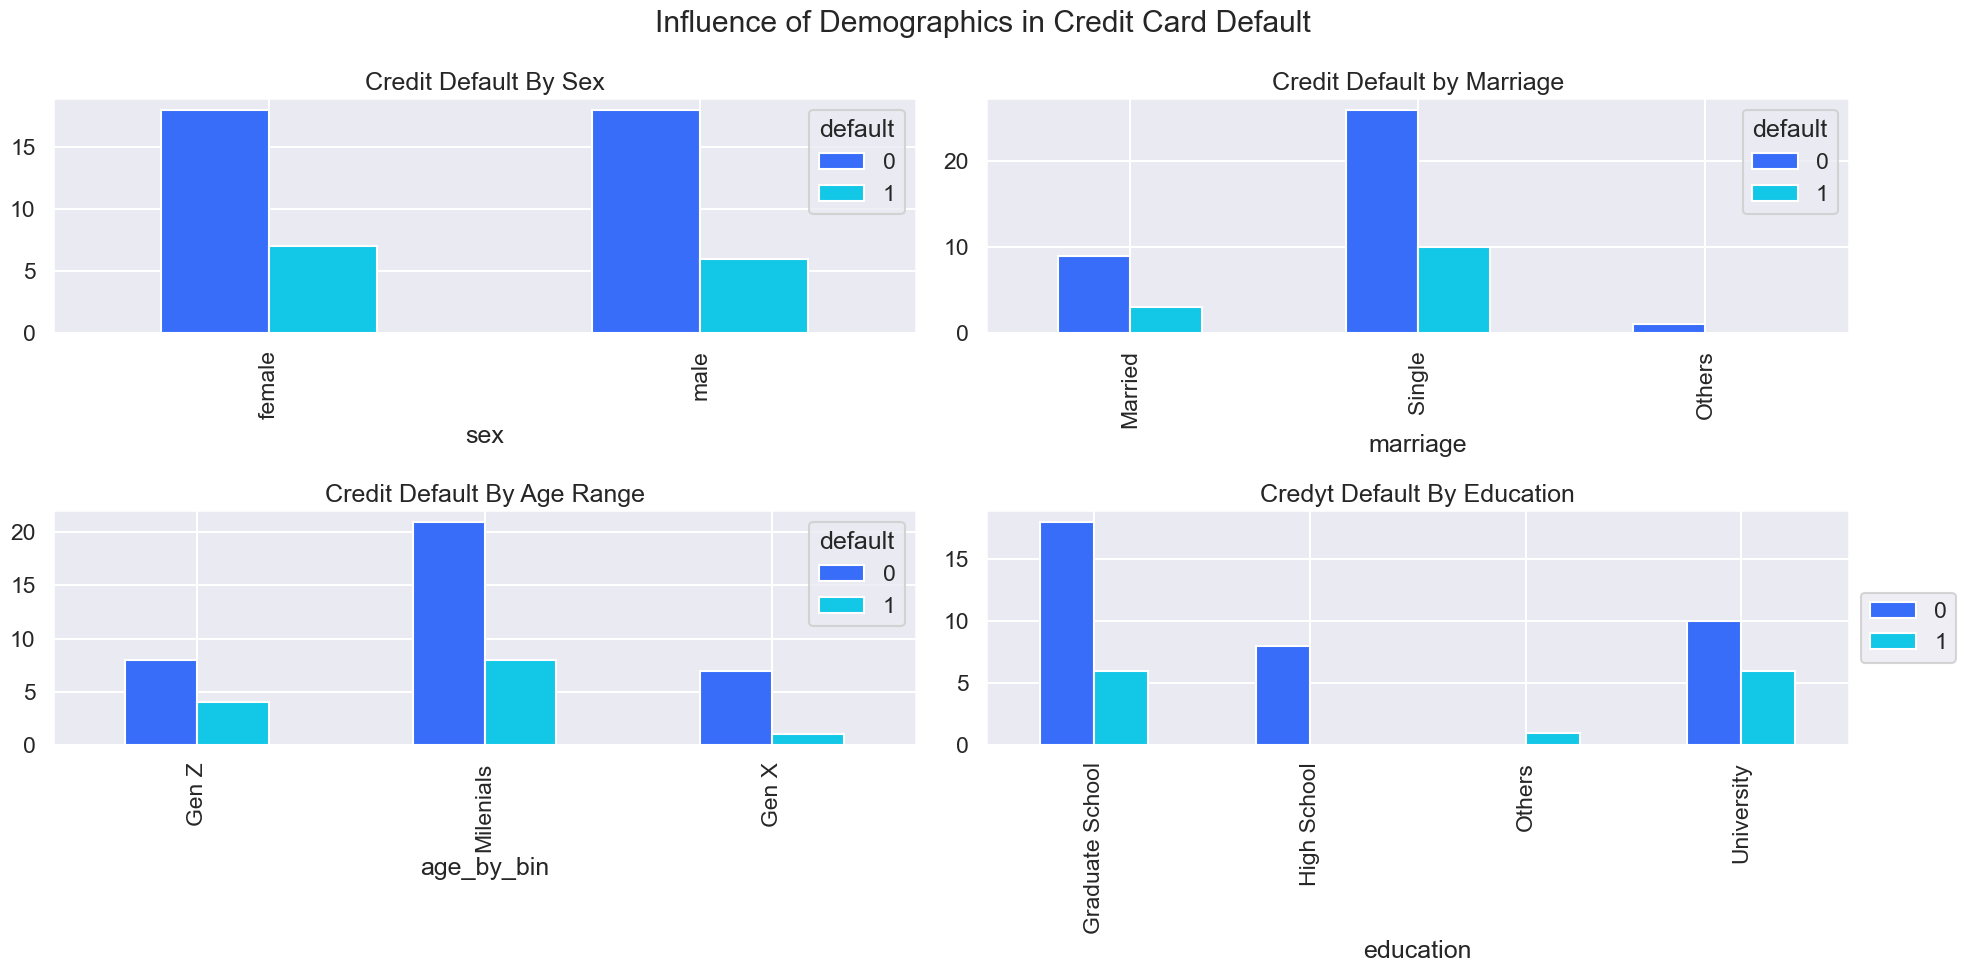

In [170]:

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Influence of Demographics in Credit Card Default')

pd.crosstab(df.sex, df.default).plot.bar(ax=axes[0,0])
axes[0,0].set_title("Credit Default By Sex")

pd.crosstab(df.marriage, df.default).plot.bar(ax=axes[0,1])
axes[0,1].set_title("Credit Default by Marriage")

pd.crosstab(df.age_by_bin, df.default).plot.bar(ax=axes[1,0])
axes[1,0].set_title("Credit Default By Age Range")

pd.crosstab(df.education, df.default).plot.bar(ax=axes[1,1])
axes[1,1].set_title("Credyt Default By Education")


fig.tight_layout()






### Reporte y Data Warehousing

Los gráficos anteriores ya constituyen un primer nivel de reportería, consecutivo al proceso de **data engineering**. Por lo cual, podemos almazenar la data que genera dichos gráficos en tablas que posteriormente se pueden almazenar en un **Data Warehouse** para análisis de negocio.

In [207]:
df_sex_to_default = pd.crosstab(df.sex, df.default).unstack(1).reset_index()
df_marriage_to_default = pd.crosstab(df.marriage, df.default).unstack(1).reset_index()
df_age_to_default = pd.crosstab(df.age_by_bin, df.default).unstack(1).reset_index()
df_education_to_default = pd.crosstab(df.education, df.default).unstack(1).reset_index()

load_data(df_sex_to_default, filename="data/3_report/df_sex_to_default.csv", index=False)
load_data(df_marriage_to_default, filename="data/3_report/df_marriage_to_default.csv", index=False)
load_data(df_age_to_default, filename="data/3_report/df_age_to_default.csv", index=False)
load_data(df_education_to_default, filename="data/3_report/df_education_to_default.csv", index=False)



Saving to: data/3_report/df_sex_to_default.csv
Saving to: data/3_report/df_marriage_to_default.csv
Saving to: data/3_report/df_age_to_default.csv
Saving to: data/3_report/df_education_to_default.csv


,default,education,0
0,0,Graduate School,18
1,0,High School,8
2,0,Others,0
3,0,University,10
4,1,Graduate School,6
5,1,High School,0
6,1,Others,1
7,1,University,6


#### Comentarios

1. Al filtar por sexo, vemos que el riesgo de default es bastante similar entre hombres y mujeres.
2. Al analizar por estado marital, vemos que hay una probabilidad de default para el caso de individuos solteros.
3. Al analizar por rango etario, vemos que los milenials son quienes tienen mayor riesgo de default, seguidos por Gen Z. Por otro lado GenX presentant un riesgo bajo.
4. Al analizar por nivel educacional, vemos que invididuos que poseen niveles de eduación superior poseen mayores niveles de riesgo de default.

### Default y variables de pago

Text(0.5, 1.0, 'Expected Payment by Default')

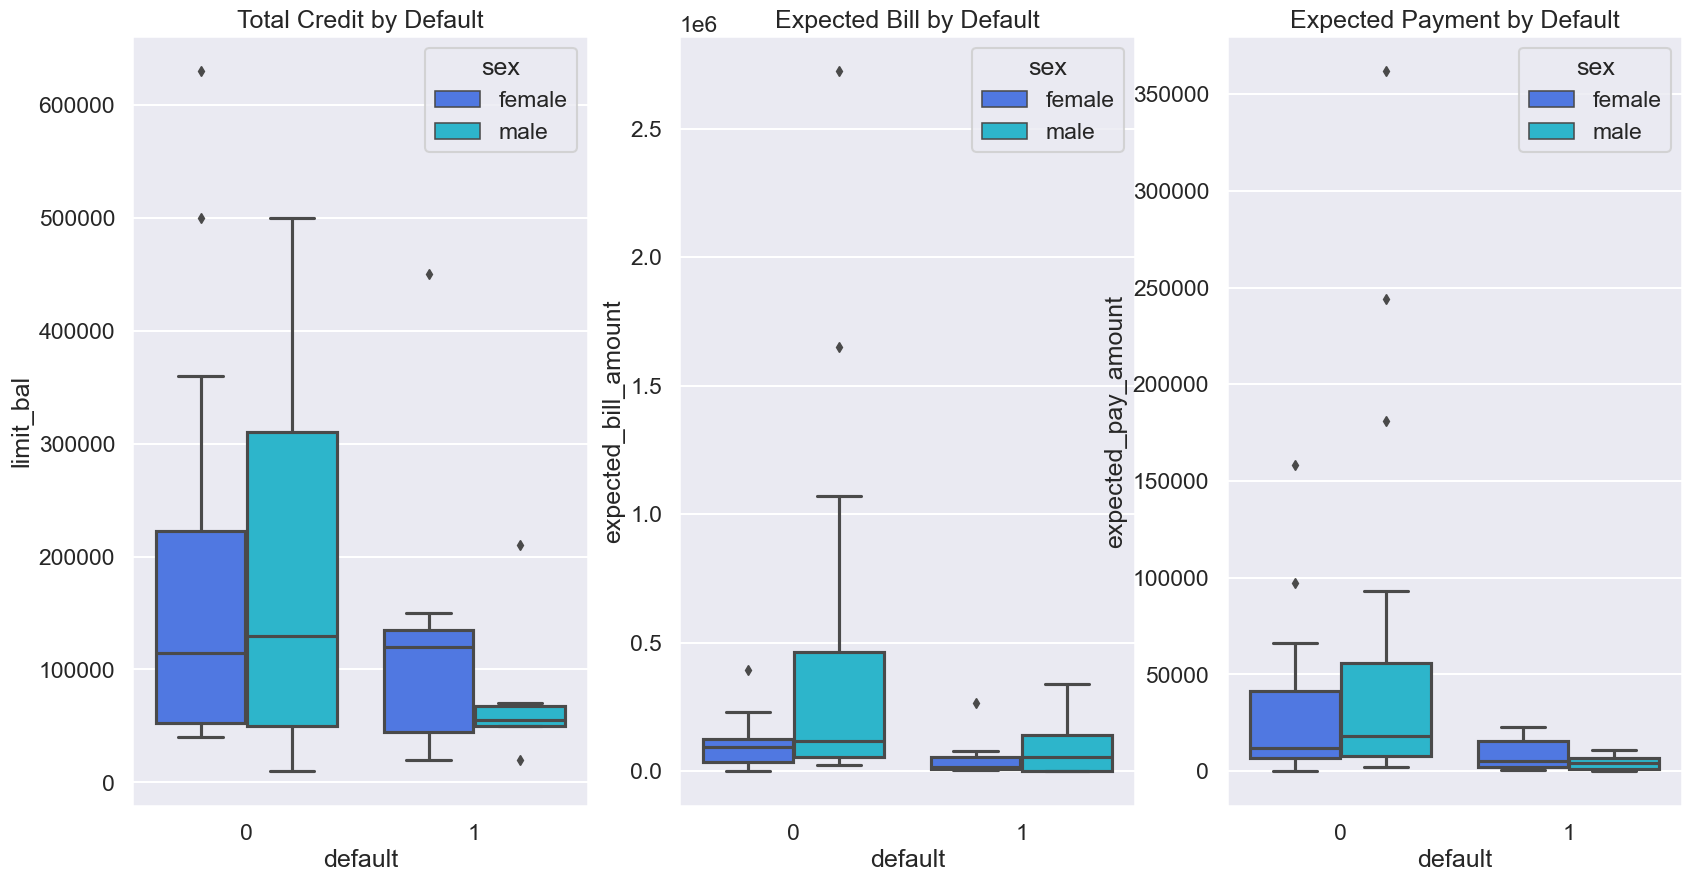

In [178]:
fix, axes = plt.subplots(1,3 , figsize=(20, 10))

sns.boxplot(data=df, x="default", y="limit_bal", hue="sex", ax=axes[0])
axes[0].set_title("Total Credit by Default")

sns.boxplot(data=df, x="default", y="expected_bill_amount", hue="sex", ax=axes[1])
axes[1].set_title("Expected Bill by Default")

sns.boxplot(data=df, x="default", y="expected_pay_amount", hue="sex", ax=axes[2])
axes[2].set_title("Expected Payment by Default")

#### Comentarios

1. Hay gran variabilidad en el acceso a crédito, tanto para hombres como para mujeres.
2. Como era de esperar, los campos `limit_bal`  y `expected_payment_amount` toman valores superiores en aquellos casos en que no hay default. Es decir, son clientes que presentan una mayor capacidad de pago mensual, y por tanto se les premia con un mayor acceso a crédito. (Ver plot en coordenada (0,0) y (0,2))
3. Las mujeres suelen tener un **monto esperado a pagar mensual** inferior a los hombres. Esto podría indicar que independiente de su estado marital, los hombres tienden a tener montos de crédito mayores que las mujeres.

### Variables de Pago, Edad y Estado Marital

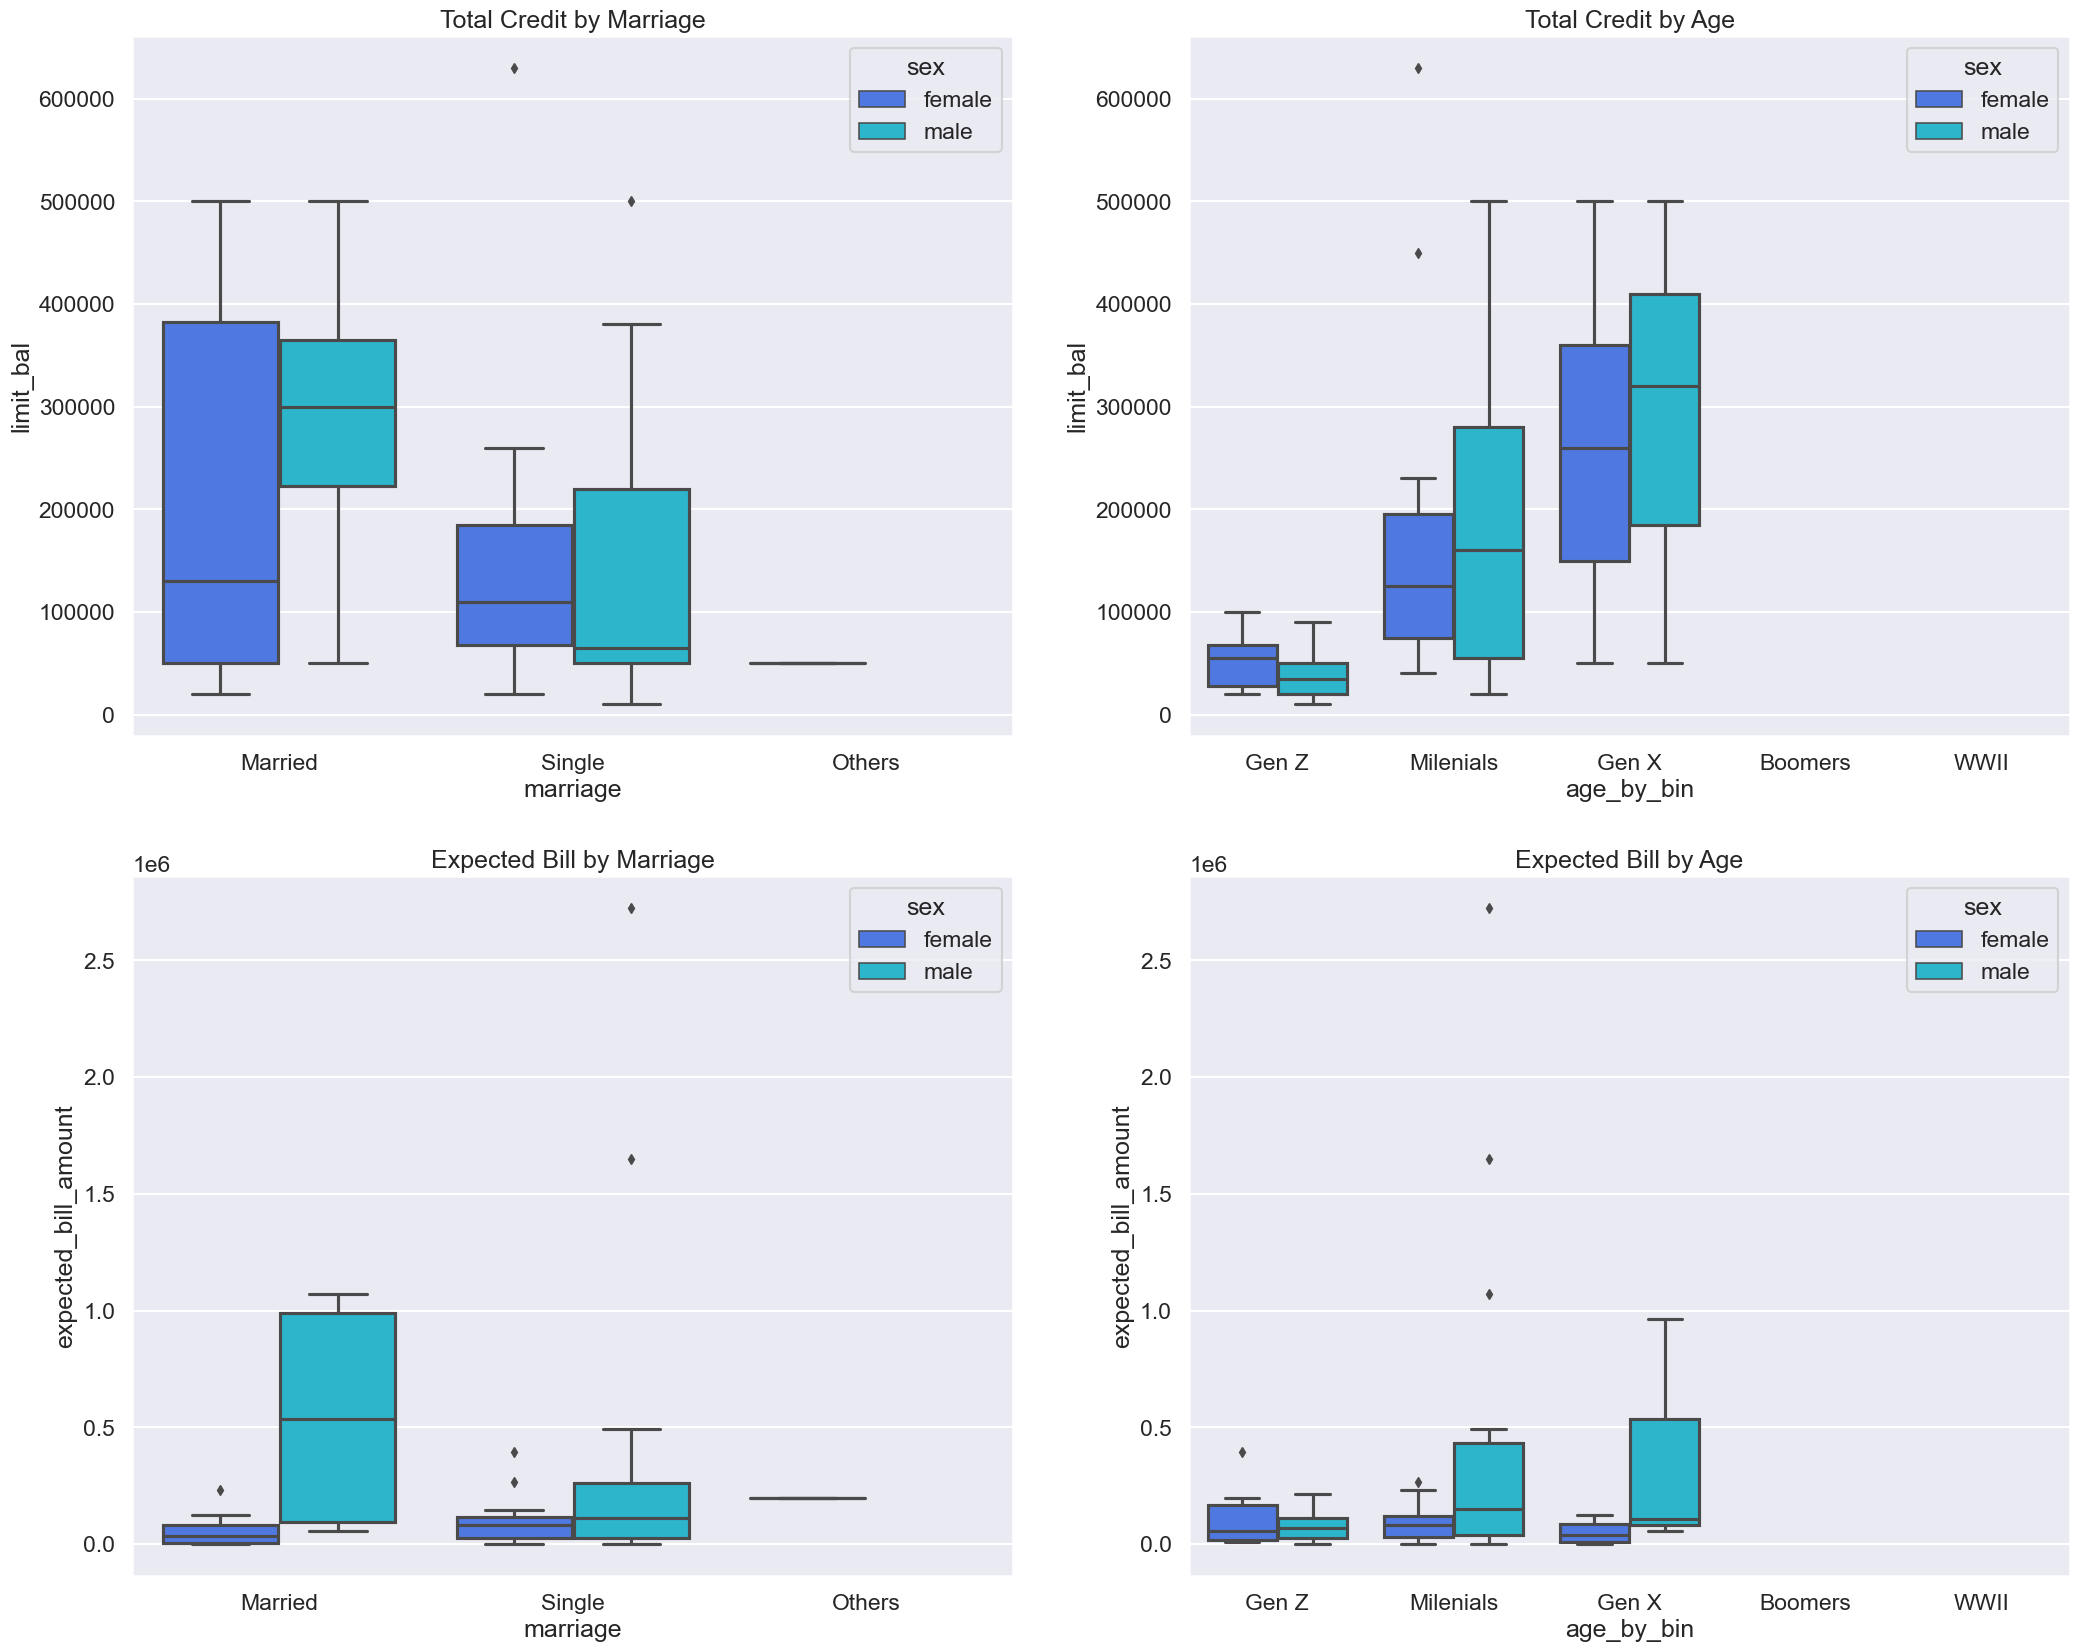

In [177]:
fix, axes = plt.subplots(2,2 , figsize=(25, 20))

sns.boxplot(data=df, x="marriage", y="limit_bal", hue="sex", ax=axes[0,0])
axes[0,0].set_title("Total Credit by Marriage")

sns.boxplot(data=df, x="age_by_bin", y="limit_bal", hue="sex", ax=axes[0,1])
axes[0,1].set_title("Total Credit by Age")


sns.boxplot(data=df, x="marriage", y="expected_bill_amount", hue="sex", ax=axes[1,0])
axes[1,0].set_title("Expected Bill by Marriage")

sns.boxplot(data=df, x="age_by_bin", y="expected_bill_amount", hue="sex", ax=axes[1,1])
axes[1,1].set_title("Expected Bill by Age")

fig.tight_layout()

### Comentarios

1. Las mujeres casadas tienen una gran variabilidad al total del crédito que tienen acceso (mayor que los hombres). Esto se puede explicar porque muchas mujeres casadas asumen labores domésticas y por lo tanto limitan su acceso a crédito.
2. Las mujeres en general tienen un valor de su cuota a pagar inferior al de los hombres, salvo en el caso de Gen Z.
3. El acceso al crédito aumenta conforme aumenta la edad del individuo. Sin embargo, el aumento al pasar de Gen Z a Milenial podría ser demasiado grande, ya que que son los Milenials quienes presentan mayores probabilidades de entrar en default.

####

### Insights Generales

En la exploración realizada, se realizaron varias observaciones particulares. A continuación se presentan 3 insights más generales del estudio:

1. El dataset tiene problemas de desbalanceo en algunos campos, lo cual puede conducir a conclusiones sesgadas. Antes de implementar una campaña real, se deben enfrentar estos problemas pra mejorar la calidad de la decisión. Formas de abordar este problema son levantar más datos de categorías sub-representadas, utilizar algoritmos de simulación y `data-augmentation` para simular clases sub-representadas.
2. Aparentemente, el sexo no tiene un efecto importante en la probabilidad de default. Sin embargo, el sexo si tiene un efecto importante en el tamaño del crédito y el monto mensual pactado a pagar. Es decir, existe uan cohorte de mujeres que aún teniendo créditos de alto tamaño, sus cuotas mensuales suelen ser bastante menores a la de los hombres.  Esto presenta posibilidades para ofrecer crédito a individuos que aún tienen capacidad de pago.
3.  Por otro lado, el nivel educacional, rango etario y estado marital si parecen tener mayor influencia en la probabilidad de default. En particular, vemos que individuos de presenten:  mayor edad o estar casados, presentan mejor capacidad de pago. Vemos que los Milenials en particular son más propensos a entrar en default, problemente debido a su relativa inestabilidad financiera combianda con mayores expectativas de consumo. En otras palabras, mayor estabilidad en la vida de una persona le dan mayor capacidad de pago, lo cual nos entrega una oportunidad para ofrecerles aumentos en sus créditos. Similarmente, individuos con menor estabilidad en sus vidas presentan mayores probabilidades de default, por lo cual es posible ofrecerles alternativas de refinanciamiento para evitar default

## Caso de Negocio

Se nos plantea el desafio de aumentar las ganancias. En el caso de Riesgo de Default en Credito, el desafio de aumntar las ganancias puede ocurrir por al menos las siguientes 2 caminos, en función de los datos que se manejan:

1. Identificar segmentos de clientes que son buenos pagadores en base a las características generadas, y ofrecerles aumentar sus lineas de credito en un monto de $X USD (personaliado) que mantenga su probabilidad de cumplir con su pago, y no caer en default. Estos segmentos, en base a nuestro analisis explorativo, pueden ser individuos de generación Gen X en adelante, o bien personas Casadas que poseen niveles moderados de deuda.
2. Identificar segmentos de clientes que son malos pagadores en base a las características generadas, y ofrecerles repactar sus créditos de manera que reduzcan su pago mensual en un monto de $X USD (personaliado), y así mejoren su probabilidad de cumplir con su pago, y no caer en default.



### Ejemplo Básico de Modelo Predictivo


Definimos un pipeline sencillo de aprendizaje supervisado para entrenar un modelo de RandomForest que clasifique a nuestros clientes en las categorías "default" y "no default".

Para ello:
1. Creamos un `one-hot encoding` de nuestras variables categóricas para poder ser procesadas numéricamente
2. Normalizamos nuestras variables numéricas utilizando una estandarización gaussiana. Dado que estamos buscando clasificar comportamientos fuera de la norma y poco frecuentes (default de pago), utilizar una distirbución normal nos ayuda a idenfitificar elementos que se alejan en 1 o más desviaciones estándar de la media.
3. Implementamos una reducción de dimensionalidad usando Principal Component Analysis (PCA). Esto debido a que los dos pasos anteriores generarán una cantidad de columnas mayor a la cantidad de files, conduciendo a que el modelo de clasificación binaria quede sobre-determinado. PCA nos permite reducir la dimensionalidad a 10 componentes principales que preservan la información. En condiciones normales, es decir, con el dataset completo, podemos estimar la cantidad adecuada de componentes a considerar.
4. Entrenamos nuestro modelo de RandomForestClassifier usando a metodología básica de aprendizaje supervisado: Entrenamos el modelo en el conjunto de entrenamiento, y lo evaluamos en nuestro conjunto de prueba. Para ello, calculamos 4 métricas de interés: Accuracy, Precisión, Recall y F1 (ver: https://en.wikipedia.org/wiki/Precision_and_recall)

In [193]:

def transform_train_model(df: pd.DataFrame) -> Tuple[pd.DataFrame, Any]:
    df_copy = df.copy()

    X = df_copy[[c for c in df_copy.columns if c != "default"]]
    y = df_copy['default']

    categorical_features = ["education", "sex", "marriage", "age_by_bin"]
    categorical_features += [f"pay_{i}" for i in range(1, 7)]
    numeric_features = [c for c in X.columns if c not in categorical_features]
    print(f"Categorical features: {categorical_features}")
    print(f"Numeric features: {numeric_features}")

    # Partition data
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=1)
    print(f"Training features shape: {X_train.shape}")
    print(f"Training target shape: {y_train.shape}\n")
    print(f"Test features shape: {X_test.shape}")
    print(f"Test target shape: {y_test.shape}")
    display(X_train.head())
    numeric_pipeline = Pipeline(steps=[
        ('scale', StandardScaler())
    ])

    categorical_pipeline = Pipeline(steps=[
        ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=True))
    ])
    full_processor = ColumnTransformer(transformers=[
        ('number', numeric_pipeline, numeric_features),
        ('category', categorical_pipeline, categorical_features)
    ])

    model = RandomForestClassifier(random_state=42, class_weight="balanced", n_estimators=100)
    pipe = Pipeline(steps=[
        ('preprocess', full_processor),
        # ('reduce_dim', PCA(n_components=10)),
        ('model', model)
    ])

    pipe.fit(X_train, y_train)

    return X_train, X_test, y_train, y_test, pipe


In [194]:
def evaluate_model(X_train, X_test, y_train, y_test, model):

    print("Evaluation of the Model")

    preds = pipe.predict(X_test)
    preds_train = pipe.predict(X_train)

    print(f"Train Accuracy: {accuracy_score(y_train, preds_train)}")
    print(f"Train Precision: {precision_score(y_train, preds_train)}")
    print(f"Train Recall: {recall_score(y_train, preds_train)}")
    print(f"Train F1: {f1_score(y_train, preds_train)}")


    print(f"Test Accuracy: {accuracy_score(y_test, preds)}")
    print(f"Test Precision: {precision_score(y_test, preds)}")
    print(f"Test Recall: {recall_score(y_test, preds)}")
    print(f"Test F1: {f1_score(y_test, preds)}")


In [195]:
X_train, X_test, y_train, y_test, pipe =transform_train_model(df=df)
evaluate_model(X_train, X_test, y_train, y_test, pipe)




Categorical features: ['education', 'sex', 'marriage', 'age_by_bin', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
Numeric features: ['bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'limit_bal', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'expected_bill', 'expected_bill_amount', 'expected_pay_amount']
Training features shape: (39, 26)
Training target shape: (39,)

Test features shape: (10, 26)
Test target shape: (10,)


,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,education,limit_bal,marriage,pay_1,...,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,sex,age_by_bin,expected_bill,expected_bill_amount,expected_pay_amount
ID,,,,,,,,,,,,,,,,,,,,,
32,30518.000,29618.000,22102.000,22734.000,23217.000,23680.000,University,50000.000,Single,2,...,1500.000,1000.000,1000.000,1000.000,716.000,male,Milenials,151869.000,151869.000,6934.000
39,0.000,780.000,0.000,0.000,0.000,0.000,Graduate School,50000.000,Single,1,...,0.000,0.000,0.000,0.000,0.000,male,Gen Z,780.000,780.000,780.000
22,316.000,316.000,316.000,0.000,632.000,316.000,University,120000.000,Married,-1,...,316.000,0.000,632.000,316.000,0.000,female,Milenials,1896.000,1896.000,1580.000
36,30265.000,-131.000,-527.000,-923.000,-1488.000,-1884.000,Graduate School,160000.000,Single,-1,...,396.000,396.000,565.000,792.000,0.000,male,Milenials,25312.000,25312.000,2280.000
20,0.000,0.000,0.000,0.000,0.000,0.000,Graduate School,180000.000,Single,1,...,0.000,0.000,0.000,0.000,0.000,female,Milenials,0.000,0.000,0.000


/Users/adolfrodeno/Documents/projects/ta-data-analysis-challenge/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Evaluation of the Model
Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0
Train F1: 1.0
Test Accuracy: 0.9
Test Precision: 0.0
Test Recall: 0.0
Test F1: 0.0


/Users/adolfrodeno/Documents/projects/ta-data-analysis-challenge/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [197]:
pipe["model"].feature_importances_

array([0.0228322 , 0.02466497, 0.03980423, 0.01884875, 0.02421796,
       0.0409615 , 0.0413944 , 0.02722914, 0.03765794, 0.02997037,
       0.04650811, 0.11225638, 0.02242504, 0.04643614, 0.04522704,
       0.08051687, 0.00401385, 0.02714331, 0.00212698, 0.01264965,
       0.01323271, 0.01672815, 0.00141017, 0.        , 0.00834666,
       0.00385142, 0.00242588, 0.00793636, 0.01306599, 0.00331552,
       0.01323878, 0.01331652, 0.02565286, 0.00763008, 0.00169925,
       0.00357289, 0.00785325, 0.00828017, 0.0072286 , 0.00449552,
       0.0089422 , 0.00784499, 0.00283654, 0.00207614, 0.01726107,
       0.00482788, 0.00051282, 0.00378293, 0.00721383, 0.00657319,
       0.00888813, 0.02956864, 0.02950602])


#### Comentarios

1. Vemos que los resultados sobre el conjunto de entrenamiento son muy buenos. Todas las métricas nos dan 100%.
2. Sin embargo, nuestras métricas en el set de prueba son bastante deficientes. Esto era de esperarse debido al tamaño del dataset. La única métrica buena es el accuracy, que nos da 90%. SIn embargo, cuado se trata de evaluar nuestra capacidad de identificar positivos (o defaults), las métricas de Precisión y Recall nos dan 0.0%, lo cual indica  el modelo no fue capaz de identificar los casos en el conjunto de prueba en que había default.
3. En un escenario real, nos intersaría optimizar las métricas de Precisión y Recall, ya que estas permiten reducir al máximo los falsos positivos (creer que un cliente hará default cuando realmente no lo hará), sin perjucio de identificar correctamente todos los defaults del dataset.

## Posibles Mejoras


La implementación anterior es un ejemplo de un pipeline básico de aprendizaje automatizado sobre el conjunto de datos.   Definir las métricas apropiadas como lo son Precisión, Recall y F1 nos permite optimizar nuestro modelo de aprendizaje automático para que detecte todos los positivos (o defaults) sin clasificar injustamente a alguien que tiene buena capacidad de pago.

Sin embargo, esta implementación tiene limitaciones debido al tiempo de implementación disponible. Posibles mejoras son:

1. Aumentar la cantidad de datos disponibles.
2. Simular datos categóricos sub-representados para evitar sesgos en las conclusiones
3. Ajustar hyperparámetros de modelos de aprendizaje automático para mejorar su desempeño en mundo real.
4. Utilizar shap values para interpretar el modelo, y análizar los campos que más influyen en la predicción de default. En ese desafío, analizamos la influencia de variables demográficas en la probabilidad de default a nivel visual. Sin embargo, es posible analizar cuantitativamente dichas características utilizando la librería shap, y con ello analizar la sensibilidad de la predicción, y por ende derivar acciones de negocios menos intuitivas que las que acabamos de plantear. Ver https://shap.readthedocs.io/en/latest/.
5. **MUY IMPORTANTE**: Utilizar modelo entrenado para simular impacto económico de aumentar tamaño de crédito en buenos pagadores, o bien en repactar tamaño de crédito en malos pagadores para aumentar sus posibilidades de pago. Esto se puede lograr fácilamente evaluando numéricamente la **sensibilidad** los campos `limit_bal` y `bill_amt`, y análizando en qué punto se convierte la predicción.